# seg2cen - convert the level-set segmentations for each frame into a set of cell centroids 

Our metrics and models are based on cells that have a location and size, so we'll be converting the segmentations that CellPose has produced into a set of cell centroids and sizes. 

Additionally we'll do some post processing to remove segmentations that are duplicated across the channels that result from, e.g., light leakage across the filters. 

First let's set up our environment and locate the segmentation files that `img2seg` has written:

In [1]:
from pathlib import Path
import itertools
import multiprocessing as mp

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches
import seaborn as sns
import skimage.io
import skimage.morphology
import cv2

from workflow_colony_formation import utils

In [2]:
config = utils.load_step_config('seg2cen', ['img2seg', ])
    
# Find (and create if necessary) input and output dirs
root_dir = Path('../../..').resolve()
relative_local_staging = config.step_local_staging_dir
absolute_local_staging = root_dir / relative_local_staging
absolute_local_staging.mkdir(parents=True, exist_ok=True)

# Load the prior manifest
parent_manifest_fn = (absolute_local_staging / "../img2seg/manifest.csv").resolve()
parent_manifest = pd.read_csv(parent_manifest_fn)
parent_manifest.head(3)

,filepath,original_czi,channel,fluorophore,time,region
0,local_staging/img2seg/seg/20170711_I01_001_M0_...,20170711_I01_001.czi,0,EGFP,0,0
1,local_staging/img2seg/seg/20170711_I01_001_M0_...,20170711_I01_001.czi,0,EGFP,1,0
2,local_staging/img2seg/seg/20170711_I01_001_M0_...,20170711_I01_001.czi,0,EGFP,2,0


Now we'll load and plot one of the segmentations. Since it is a big overview, we'll also zoom in on a small section of it to look at the segmentations there in a bit more detail.

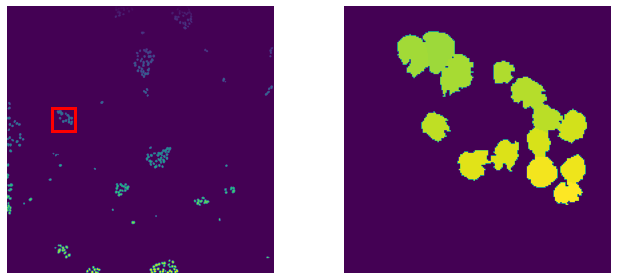

In [3]:
def load_seg(fn):
    return skimage.io.imread(str(root_dir / fn))

def plot_seg(seg, ax):
    ax.imshow(seg)
    ax.axis('off')

# Load the seg
seg_entry = parent_manifest.iloc[100]
seg = load_seg(seg_entry.filepath)

# Zoom in on a small section of it
zoom = 400,900,200,200  # x, y, w, h
rect = matplotlib.patches.Rectangle(
    zoom[:2], zoom[2], zoom[3], lw=3, ec='r', fc='none')
zoomed = seg[zoom[1]:zoom[1]+zoom[3], zoom[0]:zoom[0]+zoom[2]]

fig, axs = plt.subplots(1, 2, figsize = (10,4))
plot_seg(seg, axs[0])
axs[0].add_patch(rect)
plot_seg(zoomed, axs[1])
plt.tight_layout()

Huh, are those ones in the zoomed in region being detected as all one nucleii? Let's process their centroids and plot those as an overlay.

In [4]:
def mask_info(mask):
    """Metrics about a mask"""
    area = np.sum(mask)
    c_y, c_x = np.mean(np.nonzero(mask), 1)
    return dict(area=area, centroid_x=c_x, centroid_y=c_y)

def seg_for_cell(seg, cell_id, channel):
    """Segment a cell, creating a mask for it"""
    cell = mask_info(seg==cell_id)
    cell['cell_id'] = cell_id
    cell['channel'] = channel
    return cell
    
def seg_to_centroids(seg, channel=0):
    """Get info about all segments in an image"""
    cell_ids = np.sort(np.unique(seg))[1:]
    cells = [seg_for_cell(seg, cell_id, channel) for cell_id in cell_ids]
    return cells

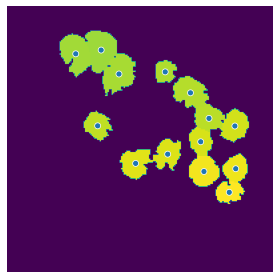

In [5]:
zoomed_cells = pd.DataFrame(seg_to_centroids(zoomed))

def plot_centroids(centroids, ax):
    """Plot the centroids by channel"""
    sns.scatterplot('centroid_x', 'centroid_y', 'channel', data=centroids, legend=False)
    ax.set(aspect = 1, 
           xlim = (0, zoom[2]),
           ylim = (zoom[3], 0),
          )
    
# Show zoomed in segment with cell centroids
fig, ax = plt.subplots()
plot_seg(zoomed, ax)
plot_centroids(zoomed_cells, ax)
plt.tight_layout()

Nope, those are all separate values in the levelset of cells. 

We have an extractor for all the cells in a frame. But we have two channels. Let's look at the other channel for this mosaic and timepoint.

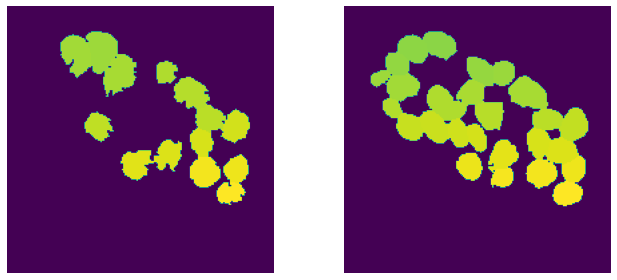

In [6]:
# Find the entry for the other channel
other_channel_seg_entry = parent_manifest[
    (parent_manifest.channel!=seg_entry.channel) & 
    (parent_manifest.time==seg_entry.time) & 
    (parent_manifest.region==seg_entry.region)].iloc[0]

# Load and display
other_seg = load_seg(root_dir / other_channel_seg_entry.filepath)
other_zoomed = other_seg[zoom[1]:zoom[1]+zoom[3], zoom[0]:zoom[0]+zoom[2]]

fig, axs = plt.subplots(1, 2, figsize = (10,4))
plot_seg(zoomed, axs[0])
plot_seg(other_zoomed, axs[1])
plt.tight_layout()

There is quite a bit of overlap in the detected nuclei between those two channels. I don't know whether this is because of light leakage across the filter or some other property of the fluorescence, but we can correct for it by deduping the centroids. Let's take a look at the centroids for each channel, overlaid on each other. 

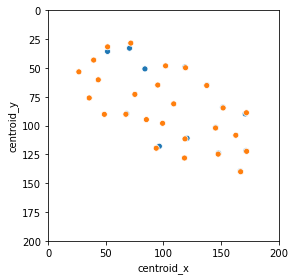

In [7]:
zoomed_cells = pd.DataFrame(seg_to_centroids(zoomed, 0) + seg_to_centroids(other_zoomed, 1))

# Show zoomed in segment with cell centroids
fig, ax = plt.subplots()
plot_centroids(zoomed_cells, ax)
plt.tight_layout()

We will apply an erosion to each mask and omit overlapping cells to de-dupe from one channel to the next.

In [8]:
def erosion(seg, area_fraction=0.25):
    """Perform binary erosion on each cell until area reachs fraction of original"""
    new = np.zeros_like(seg)
    cell_ids = np.sort(np.unique(seg))[1:]
    cells = []
    for cell_id in cell_ids:
        mask = (seg==cell_id).astype(np.uint8)
        area = np.sum(mask)
        kernel = cv2.getStructuringElement(1, (3,3))
        while np.sum(mask) > area_fraction * area:
            #mask = skimage.morphology.binary_erosion(mask)
            mask = cv2.erode(mask, kernel)
        new += mask*cell_id
    return new

def seg_to_centroids(seg, other=None, channel=0):
    """Retake the centroids for each segment in an image, but with the option to exclude 
    those that overlap with an eroded mask from a neighboring channel
    """
    cell_ids = np.sort(np.unique(seg))[1:]
    cells = []
    if other is None:
        other = np.zeros_like(seg)
    seg_erode = erosion(seg)
    other_erode = erosion(other)
    for cell_id in cell_ids:
        erode_mask = seg_erode==cell_id
        if np.sum(erode_mask*other_erode)>0:
            continue
        cells.append(seg_for_cell(seg, cell_id, channel))
    return cells

def segs_to_centroids(seg, other_seg):
    cells = seg_to_centroids(seg)
    cells += seg_to_centroids(other_seg, seg, 1)
    return cells

Now we can try our deduped centroid detection on our zoomed in segment. 

Side note: applying this erosion across the images is the most computationally expensive step here. 

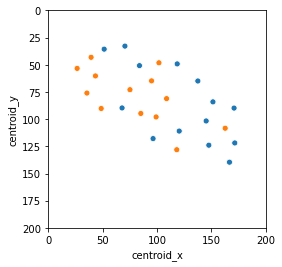

In [9]:
zoomed_cells = pd.DataFrame(segs_to_centroids(zoomed, other_zoomed))

# Show zoomed in segment with cell centroids
fig, ax = plt.subplots()
plot_centroids(zoomed_cells, ax)

That is what we want! Let's go through and do it to each. First we need a list of matching rows (both channels for a single time point in a given region), so we'll make that and then find the centroids for each set.

In [10]:
# Create params of matching row indices to process channel pairs
params = []
for ind, row in parent_manifest.iterrows():
    match = parent_manifest[
        (parent_manifest.time==row.time) & 
        (parent_manifest.region==row.region) & 
        (parent_manifest.channel!=row.channel) 
    ]
    assert len(match)<=1
    if len(match)==0:
        continue
    other_ind = match.iloc[0].name
    if (other_ind, ind) not in params:
        params.append((ind, other_ind))
if config.interactive:
    params = params[:2]
        
def centroids_by_rows(row_inds):
    if parent_manifest.iloc[row_inds[0]].channel==1:
        row_inds = row_inds[::-1]
    rows = [parent_manifest.iloc[i] for i in row_inds]
    centroids = segs_to_centroids(load_seg(rows[0].filepath), 
                                  load_seg(rows[1].filepath))
    for centroid in centroids:
        row = rows[centroid['channel']]
        centroid.update(dict(original_czi=row.original_czi,
                             fluorophore=row.fluorophore, 
                             time=row.time, 
                             region=row.region)) 
    return centroids

In [11]:
with mp.Pool(mp.cpu_count()) as pool:
    centroids = pool.map(centroids_by_rows, params)
centroids = pd.DataFrame(itertools.chain(*centroids))
centroids.head()

,area,centroid_x,centroid_y,cell_id,channel,original_czi,fluorophore,time,region
0,89,1642.584270,2.685393,1,0,20170711_I01_001.czi,EGFP,0,0
1,402,1762.671642,13.833333,2,0,20170711_I01_001.czi,EGFP,0,0
2,399,1784.869674,40.010025,3,0,20170711_I01_001.czi,EGFP,0,0
3,490,923.134694,62.163265,4,0,20170711_I01_001.czi,EGFP,0,0
4,225,1673.026667,63.533333,5,0,20170711_I01_001.czi,EGFP,0,0


And finally we'll update the manifest to reflect the output CSV and save (if called from a step).

In [12]:
manifests = []
for region in centroids.region.unique():
    by_region = centroids[centroids.region==region]
    original_czi = by_region.iloc[0].original_czi
    fn = original_czi[:original_czi.rfind("_")]+'.csv'
    by_region.to_csv(absolute_local_staging / fn, float_format="%0.1f", index=False)
    manifests.append(dict(filepath=relative_local_staging/fn, 
                          original_image_series=fn[:-4],
                          region=region))
    
config.manifest = pd.DataFrame(manifests)
config.metadata_columns = ['original_image_series', 'region']
utils.dump_step_config(config)